# Задача 1. Линейная регрессия, метод градиентного спуска
Мирошников Владислав Игоревич 471 группа

Задача
- [+] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [+] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целового признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [+] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
- [+] Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [+] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- [+] Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.
- [+] При обучении моделей использовать масштабирование данных.
- [+] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [+] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с вашей реализацией.
- [+] Повторить тоже самое, но используя кросс-валидацию.
- [+] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.
- [+] * (+1 балл) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE).
- [+] * (+1 балл) Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [+] * (+2 балла) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.
- [+] * (+2 балла) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.


In [70]:
import warnings

# необходимые импорты
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import ndarray

warnings.filterwarnings('ignore')  # отключаем предупреждения
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
np.random.seed(20)

## Реализация градиентного спуска

In [69]:
def gradient_descent(X: ndarray, y: ndarray, alpha=1, lambda_value=0.001, epsilon=1E-2) -> ndarray:
    m = np.shape(X)[0]  # количество выборки
    n = np.shape(X)[1]  # количество признаков
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    W = np.random.randn(n + 1)

    cost_prev = -1

    while True:
        y_estimated = X.dot(W)

        error = y_estimated - y

        # Считаем L2 терм * alpha, не регуляризуем w0, т.к. он соответствует фиктивному признаку
        L2_reg_term = alpha * np.sum(np.square(W[1:]))

        cost_curr = (1 / n) * np.sum(error ** 2) + L2_reg_term

        gradient = (1 / m) * (X.T.dot(error) + (alpha * W))
        W = W - lambda_value * gradient
        # условие остановки алгоритма
        if abs(cost_curr - cost_prev) < epsilon:
            break

        cost_prev = cost_curr

    return W

## Датасет

В качестве набора данных возьмем датасет с информацией о марках машин, их характеристик, включая скорость, размеры (длину, ширину), стоимость и т.д.

Приведем некоторые признаки/группы признаков:
- **Car Name**: название автомобиля
- **car_ID**: ID автомобиля в таблице
- **fueltype**: вид топлива, бензин или газ
- **doornumber**: количество дверей
- **Признаки размеров**: длина, ширина, высота
- **cylindernumber**: количество цилиндров в двигателе
- **peakrpm**: количество оборотов двигателя в минуту
- **enginesize**: размер двигателя
- **horsepower**: количество лошадиных сил
- **wheelbase**: размер колесной базы
- **citympg**: расхода топлива на галон в городе
- **highwaympg**: расход топлива на галон на шоссе

Будем предсказывать целевой признак **price** на основе других признаков.

Считаем датасет и выведем первые 5 элементов

In [3]:
df = pd.read_csv("data\\car_price.csv")
print('Количество строк и столбцов: ', df.shape)

df.head()

Количество строк и столбцов:  (205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Первичный и разведочный анализ данных

Посмотрим, есть ли пропущенные значения:

In [4]:
df.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

Как видим, пропущенных значений нет.

Рассмотрим график распределения цены автомобилей

Text(0.5, 1.0, 'Распределение цены автомобилей')

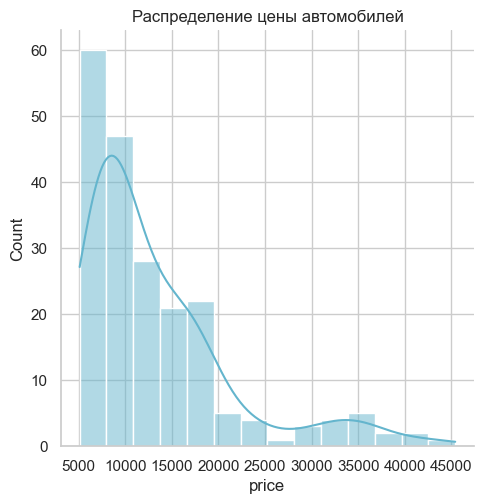

In [5]:
sns.set(style='whitegrid')
ax = sns.displot(df['price'], kde=True, color='c')
plt.title('Распределение цены автомобилей')

По графику видно ассиметричное распределение цены. При этом заметно, что больше всего автомобилей находятся в ценовом диапазоне от 5000 до 15000 денежных единиц. Выведем среднюю цену.

In [6]:
df['price'].mean()

13276.710570731706

Посмотрим, какие у нас есть различные виды кузовов, а также на средную цену автомобилей по каждому виду кузова.

In [7]:
df['carbody'].value_counts()

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64

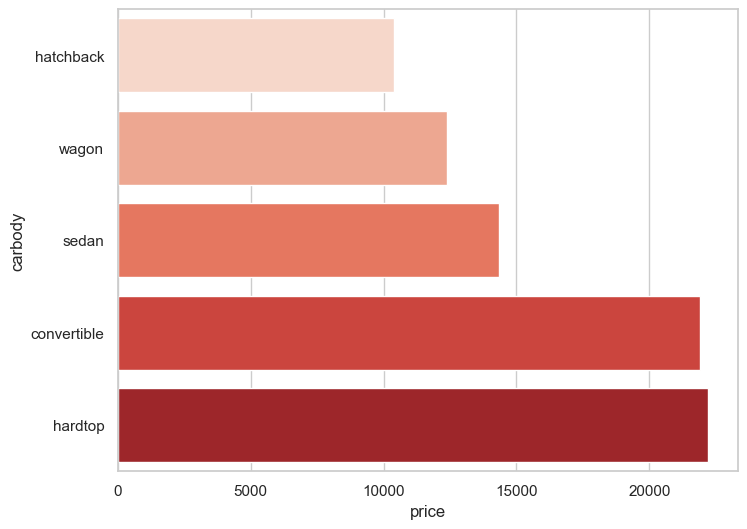

In [8]:
price = df['price'].groupby(df.carbody).mean().sort_values(ascending=True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(x=price.head(), y=price.head().index, palette='Reds')

Видно, что кабриолеты и хардтопы вдвое дороже хэтчбэков и почти вдвое фургонов и седанов.

Рассмотрим другие зависимости между признаками:

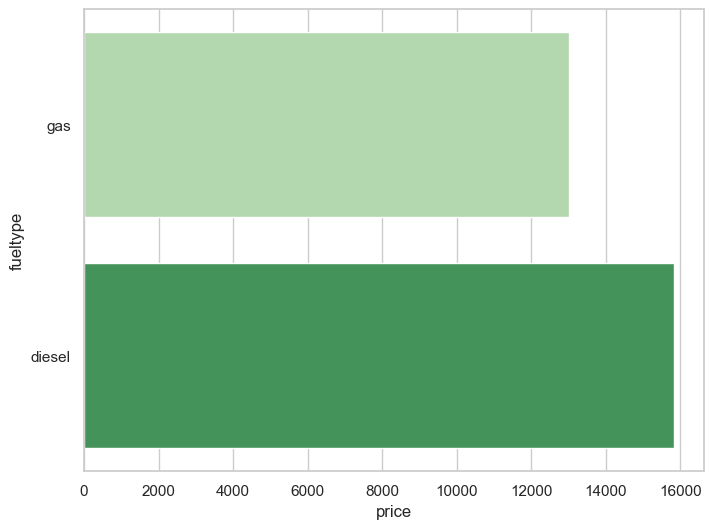

In [9]:
price = df['price'].groupby(df.fueltype).mean().sort_values(ascending=True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(x=price.head(), y=price.head().index, palette='Greens')

Как видно на полученном графике, в среднем машины с дизельной системой топлива немного дороже, чем с машины с системой на бензине.

Рассмотрим другие виды графиков, чтобы попытаться определить, какие признаки у нас важные и влияют на целевой, а какие влияют в меньшей степени или почти не влияют.

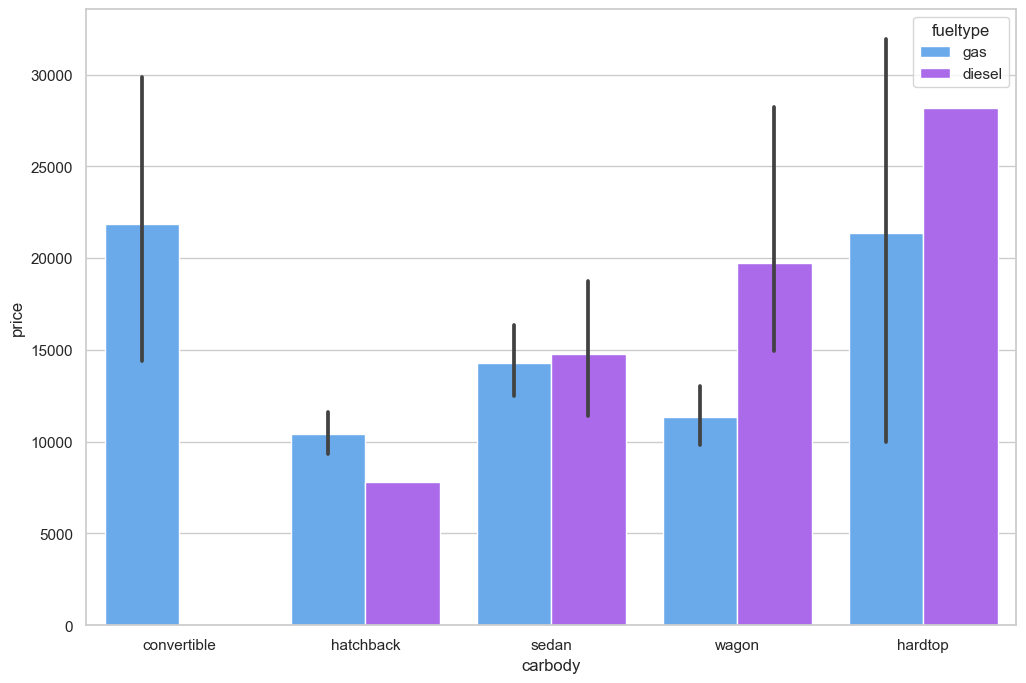

In [10]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='carbody', y='price', hue='fueltype', data=df, palette='cool')

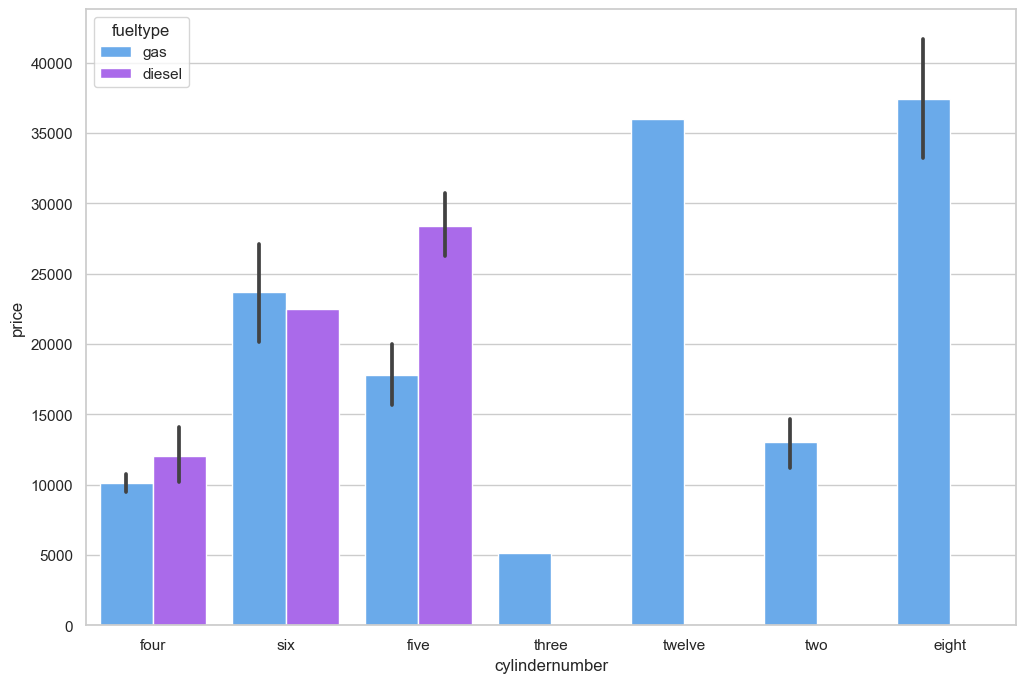

In [11]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x=df['cylindernumber'], y='price', hue='fueltype', data=df, palette='cool')

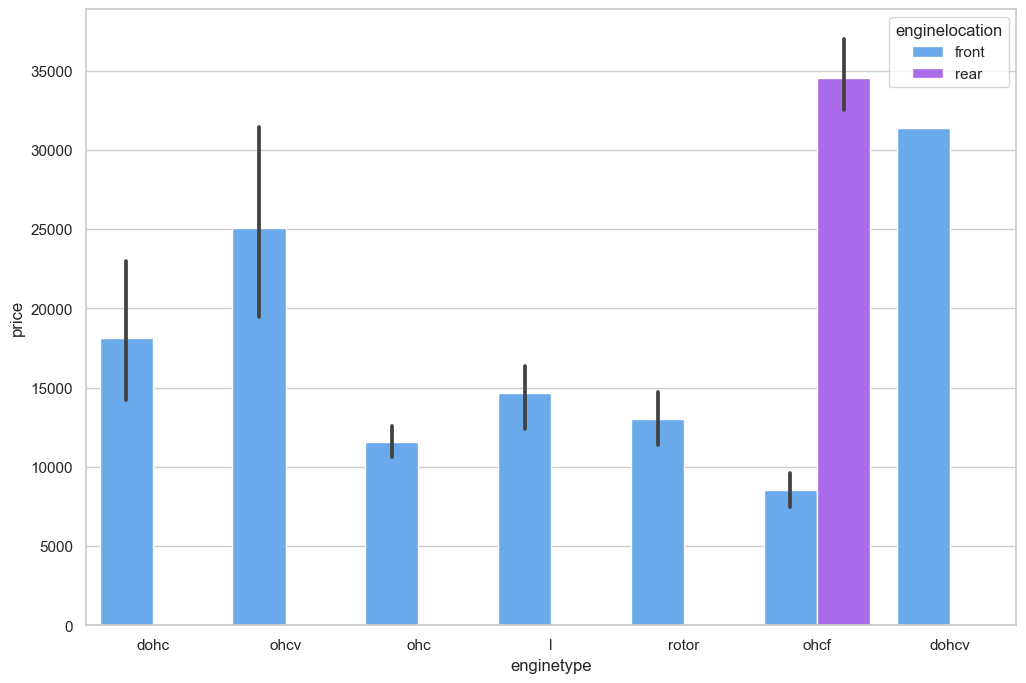

In [12]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='enginetype', y='price', hue='enginelocation', data=df, palette='cool')

По полученным результатам можно сделать следующие выводы:
- Как было замечено ранее, кабриолеты и хардтопы в среднем дороже других видов машин, при этом если смотреть разбиение по виду кузова с поправкой на признак **fueltype**, то видно, что дизельные варианты одних и тех же видов машин дороже их бензиновых аналогов за исключением хэтчбэков.
- По графику зависимости цены от количества цилиндров в двигателе видно, что с ростом количества цилиндров растет и цена. В целом логично, что обычный автомобиль с 2 или 4 цилиндрами будет дешевле, чем автомобиль с 8 или 12 цилиндрами, так как обычно это уже спортивные автомобили или суперкары. Данный признак **cylindertype** определенно влияет на наш целевой признак и имеет отличную от 0 корреляцию, но степень этой зависимости оценим далее.
- По графику зависимости цены от типа двигателя с учетом разделения на расположение двигателя видно, что типы двигателей ohcv и dohcv дороже остальных, причем наибольшую цену имеет тип двигателя ohcf, расположенный сзади, что наверное, говорит о спортивной машине в данном случае. Однако по данному графику нельзя сказать, что признак **enginetype** как-то сильно влияет на наш целевой признак.

In [13]:
price = df['price'].groupby(df.doornumber).mean().sort_values(ascending=True)
pd.crosstab(price, price.index, margins=True).style.background_gradient()

col_0,four,two,All
price,,,
12989.924078,0,1,1
13501.152174,1,0,1
All,1,1,2


Видно, что средняя цена автомобилей с 2 и 4 дверями не сильно отличается.

Рассмотрим графики зависимостей нашего целевого признака от различных количественных признаков (кол-во лошадиных сил, размер двигателя и т.д.):

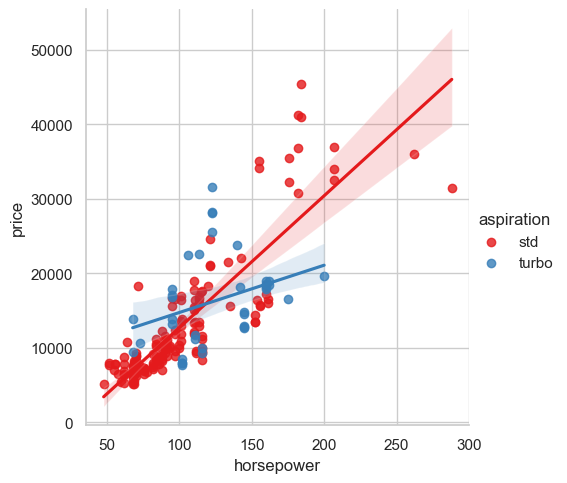

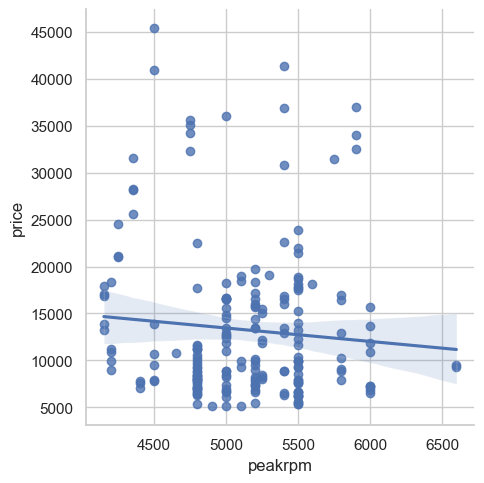

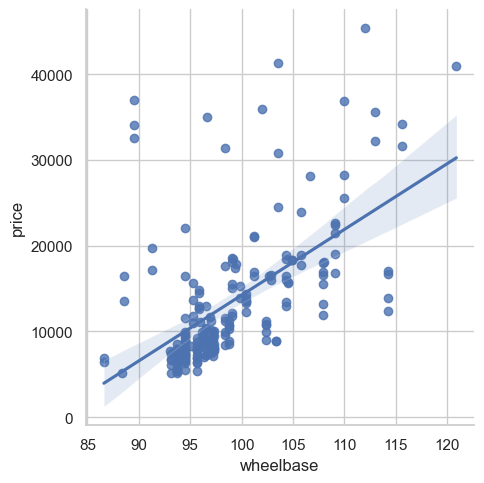

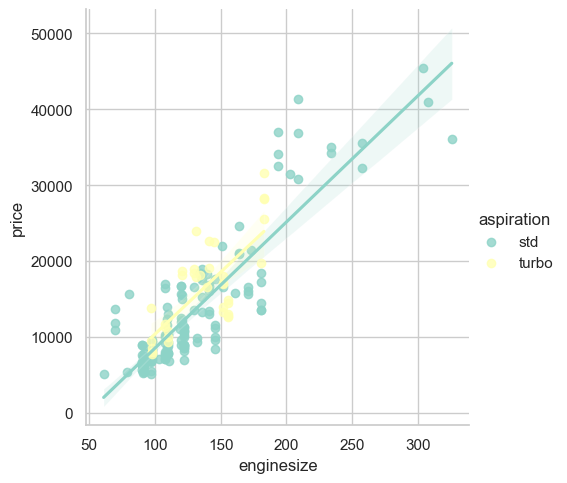

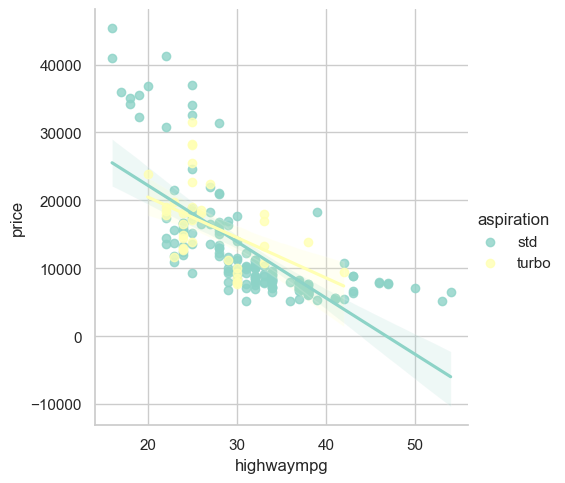

In [14]:
ax = sns.lmplot(x='horsepower', y='price', data=df, hue='aspiration', palette='Set1')
ax = sns.lmplot(x='peakrpm', y='price', data=df, palette='Set2')
ax = sns.lmplot(x='wheelbase', y='price', data=df, palette='Set3')
ax = sns.lmplot(x='enginesize', y='price', data=df, hue='aspiration', palette='Set3')
ax = sns.lmplot(x='highwaympg', y='price', data=df, hue='aspiration', palette='Set3')

Можно сделать следующие выводы:
- С ростом количества лошадиных сил растет и цена автомобиля.
- Признак **peakrpm** практически не влияет на целевой признак и, скорее всего, будет удален как ненужный признак перед обучением модели.
- С ростом размера колесной базы и размера двигателя цена растет достаточно линейно, поэтому можно считать, что признаки **wheelbase** и **enginesize** важны для нас.
- С ростом значения признака **highwaympg** цена уменьшается. Здесь мы видим обратную зависимость, причем также достаточно линейную. Данный признак также важен и по всей видимости имеет отрицательную корреляцию с целевым.

In [15]:
df['fuelsystem'].value_counts()

mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: fuelsystem, dtype: int64

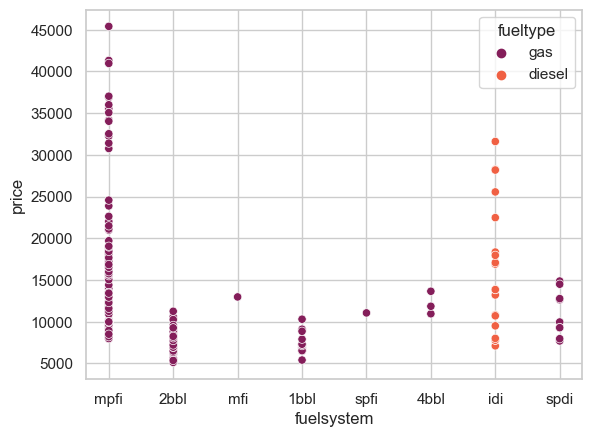

In [16]:
ax = sns.scatterplot(x='fuelsystem', y='price', hue='fueltype', data=df, palette='rocket')

У признака **fuelssytem** есть 8 разных значений, однако по графику нельзя однозначно сделать вывод, насколько сильно данный признак влияет на целевой.

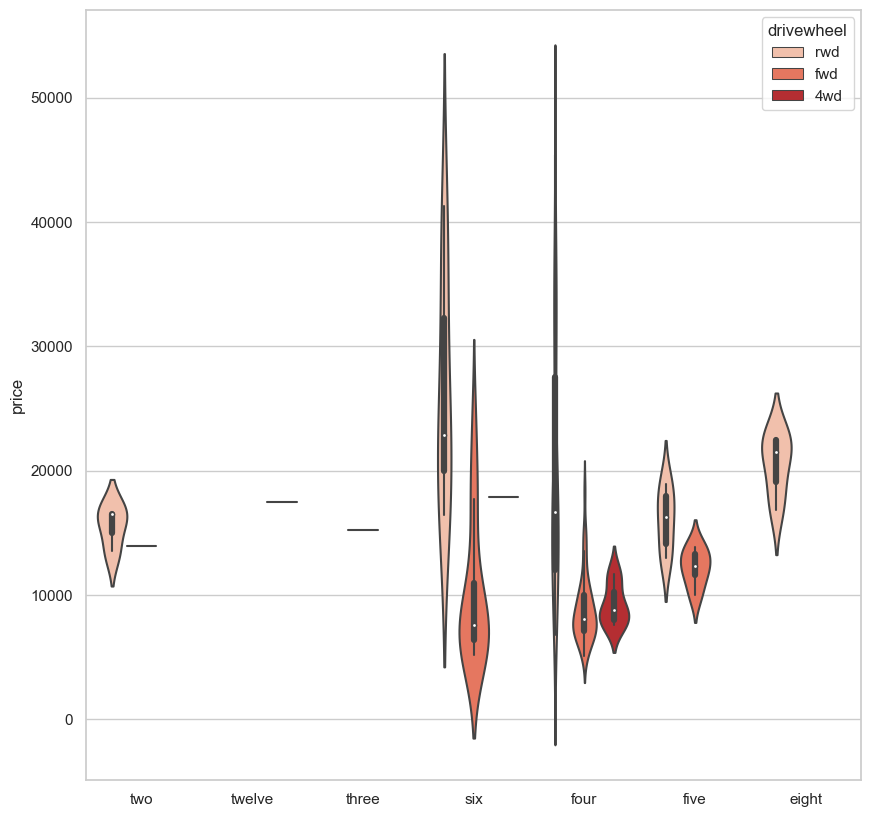

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x=sorted(df.cylindernumber, reverse=True), y='price', data=df, orient='v', hue='drivewheel',
                    palette='Reds')

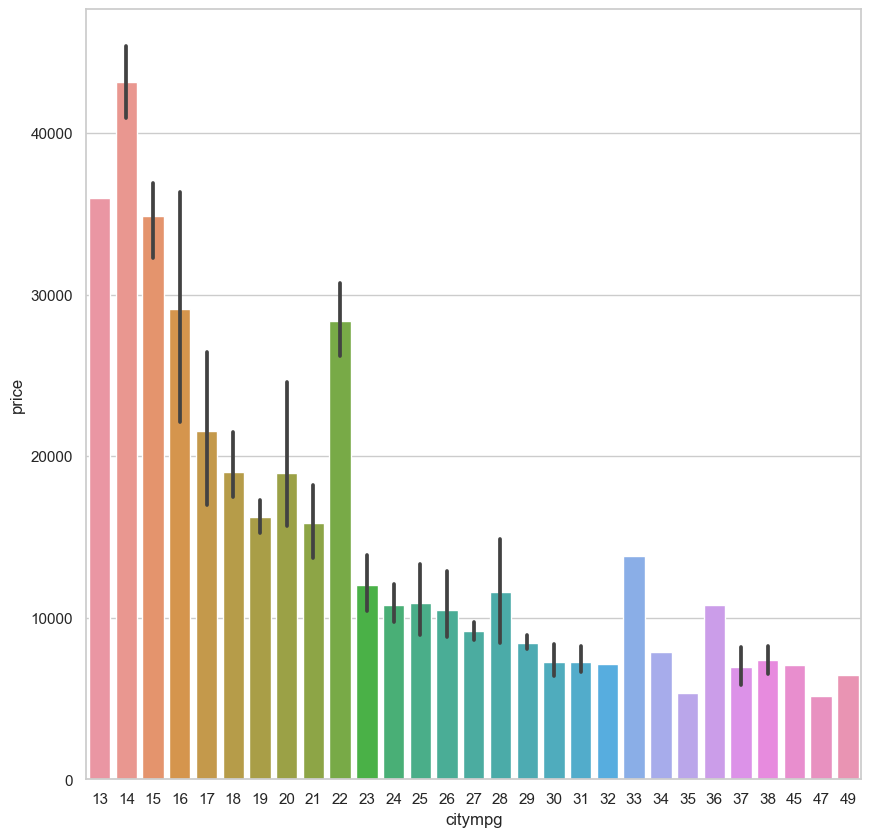

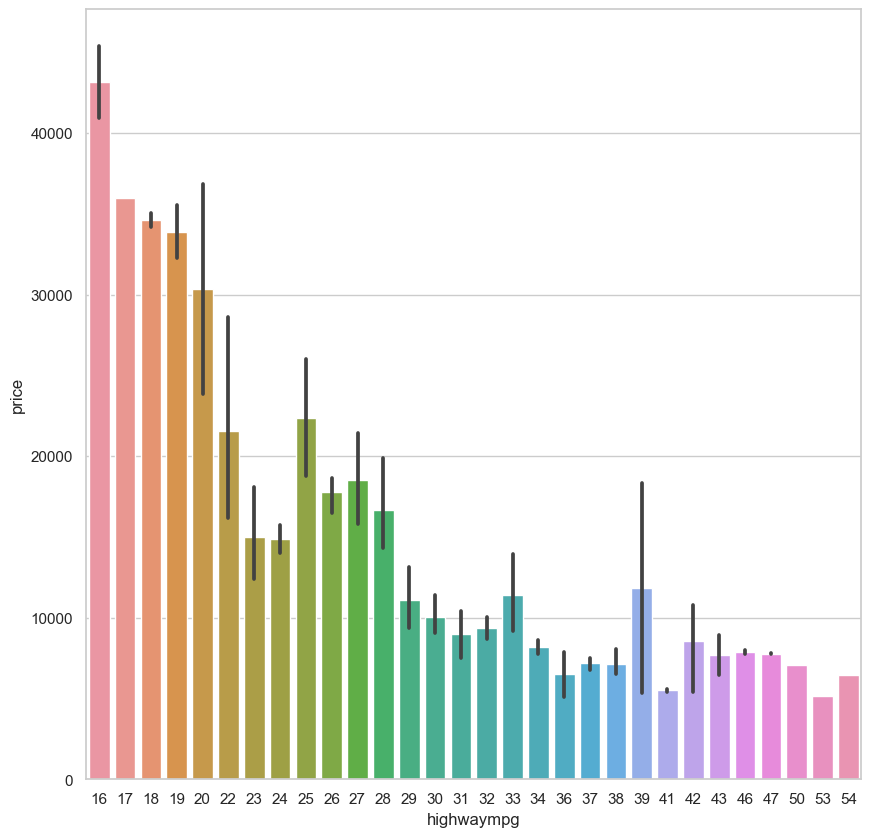

In [18]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.barplot(x='citympg', y='price', data=df)
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.barplot(x='highwaympg', y='price', data=df)
plt.show()

По данным графикам видно, что с увеличением расхода автомобиля как по городу, так и по шоссе, цена наоборот уменьшается. Однако заметно, что данные признаки важны и влияют на целевой, имея отрицательный коэффициент корреляции, отличный от 0.

### Преобразования данных

Для начала нужно удалить признаки, которые не очень удобны или не важны: **car_ID** и **CarName**. Они не могут сильно влиять на наш целевой признак и являются не нужными, так как, например, **car_ID** это порядковый признак, обозначающий уникальный номер автомобиля в датасете, а **CarName** фактически является уникальным строковым значением для каждого автомобиля.

Далее сделаем трансформацию категориальных признаков в количественные.


In [19]:
df.drop(['car_ID', 'CarName'], axis=1, inplace=True)
df['fueltype'].replace(['gas', 'diesel'], [0, 1], inplace=True)
df['aspiration'].replace(['std', 'turbo'], [0, 1], inplace=True)
df['doornumber'].replace(['two', 'four'], [0, 1], inplace=True)
df['carbody'].replace(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'], [0, 1, 2, 3, 4], inplace=True)
df['drivewheel'].replace(['rwd', '4wd', 'fwd'], [0, 1, 2], inplace=True)
df['enginelocation'].replace(['front', '4wd', 'rear'], [0, 1, 2], inplace=True)
df['enginetype'].replace(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf', 'dohcv'], [0, 1, 2, 3, 4, 5, 6], inplace=True)
df['cylindernumber'].replace(['four', 'six', 'five', 'two', 'three', 'twelve', 'eight'], [0, 1, 2, 3, 4, 5, 6],
                             inplace=True)
df['fuelsystem'].replace(['mpfi', '2bbl', '1bbl', '4bbl', 'idi', 'spdi', 'mfi', 'spfi'], [0, 1, 2, 3, 4, 5, 6, 7],
                         inplace=True)
df.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,0,0,0,0,0,0,88.6,168.8,64.1,...,130,0,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,0,0,0,0,0,0,88.6,168.8,64.1,...,130,0,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,0,0,0,1,0,0,94.5,171.2,65.5,...,152,0,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,0,0,1,2,2,0,99.8,176.6,66.2,...,109,0,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,0,0,1,2,1,0,99.4,176.6,66.4,...,136,0,3.19,3.40,8.0,115,5500,18,22,17450.0


Построим диаграмму корреляции оставшихся признаков.

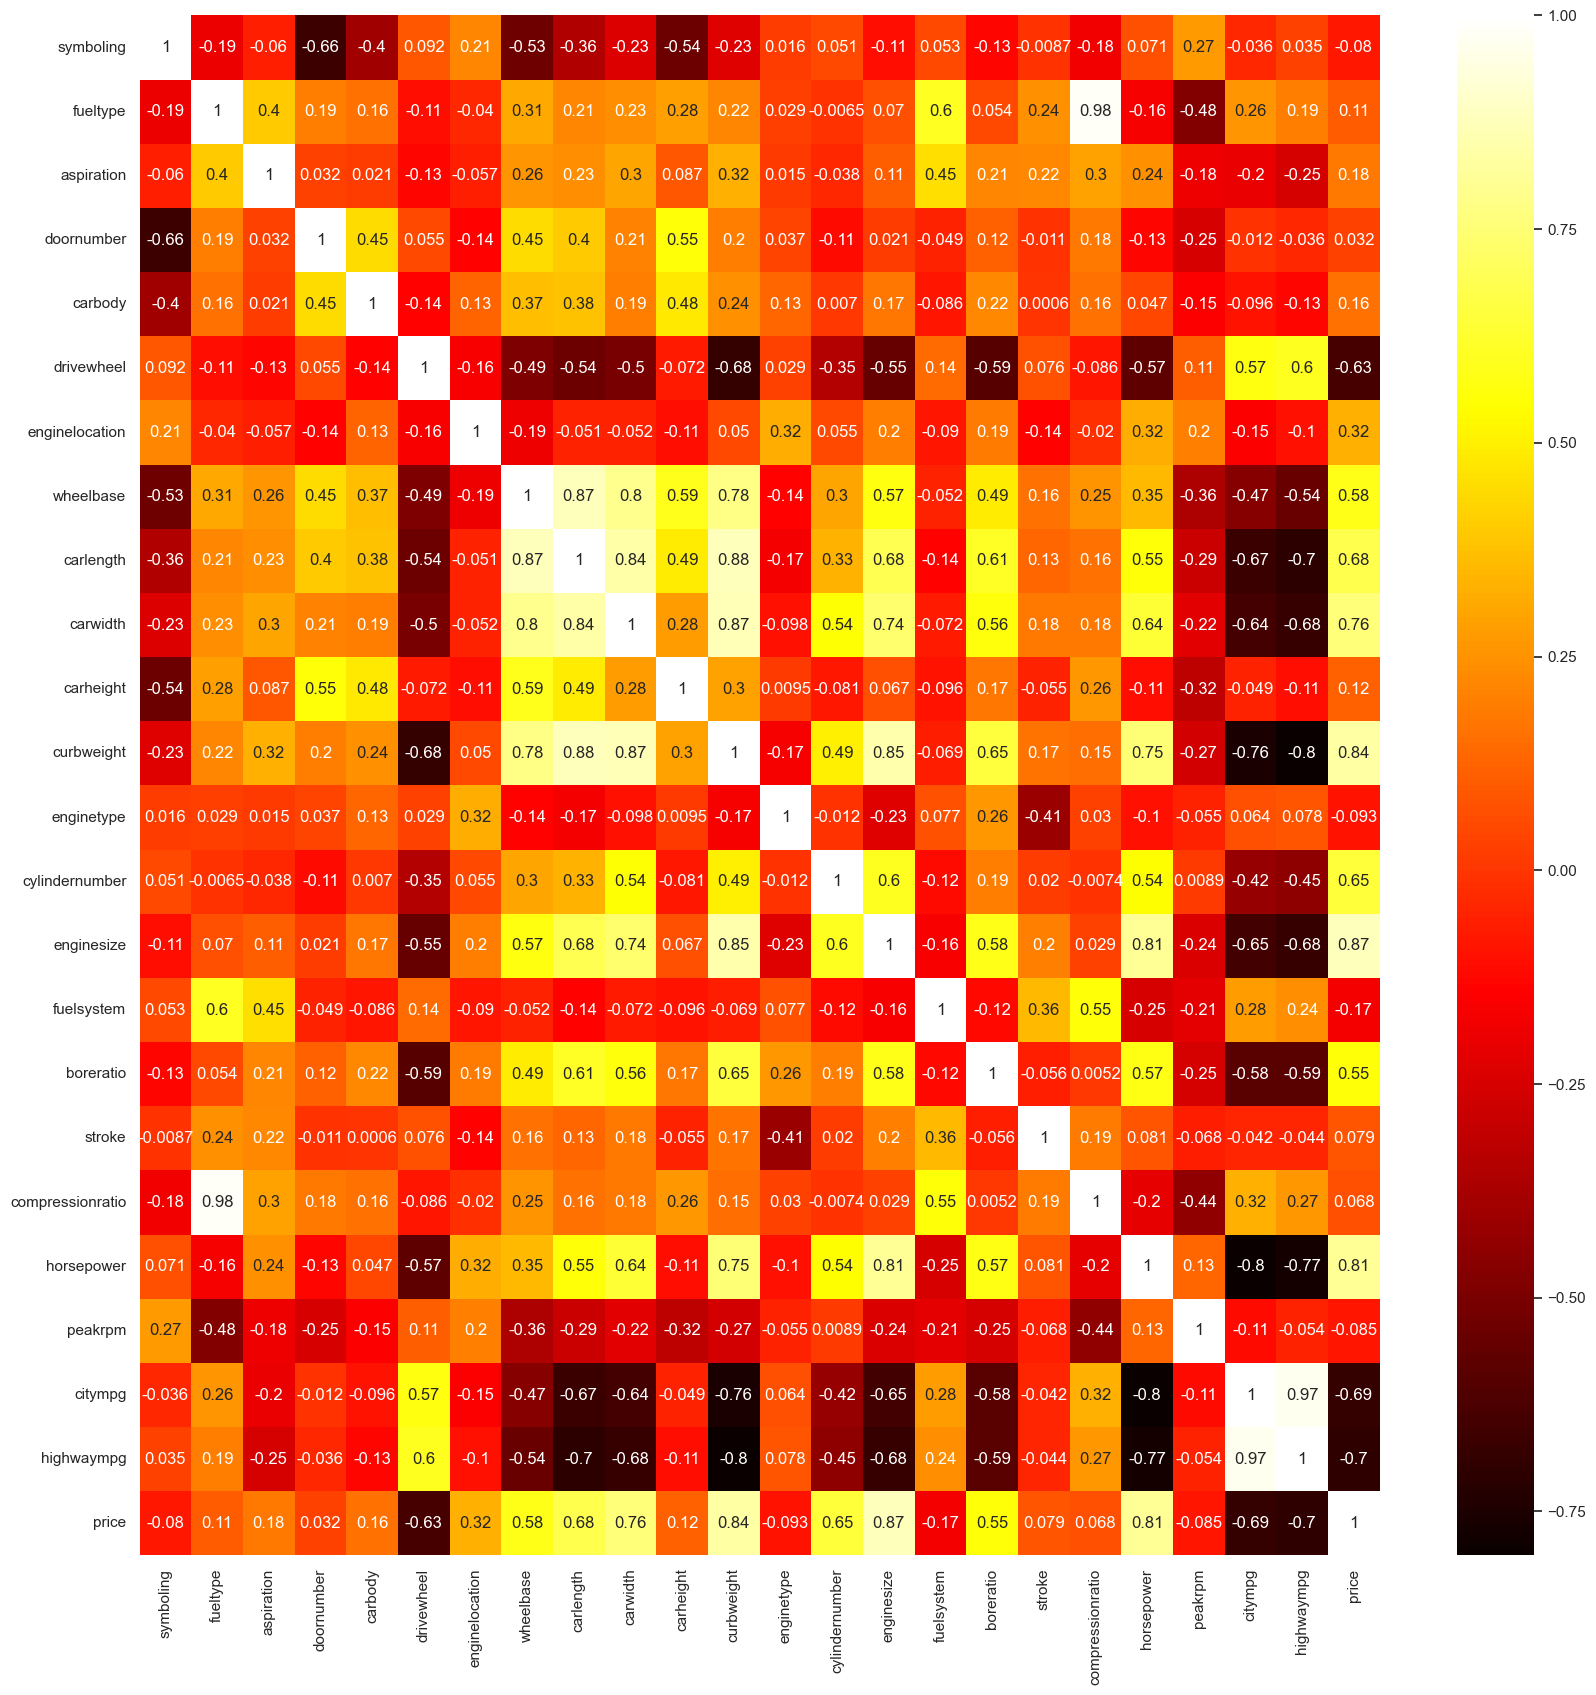

In [20]:
f, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(df.corr(), annot=True, cmap='hot')

**Выводы**:

Как видно по полученной таблице, не все признаки состоят в сильной корреляции с целевым. Однако есть те признаки, которые имеют сильную корреляцию с целевым, например, **enginesize** или **curbweight**.

При этом в таблице также виден "квадрат сильной корреляции" между признаками размеров (**carlenght**, **carwidth** и т.д.). Многие ячейки в данном квадрате имеют корреляцию, приближенную к 1.

### Разбиение данных на обучающую и тестовую выборки

In [21]:
x = df.drop(['price'], axis=1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

Используем также масштабирование данных

In [22]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Recursive Feature Elimination (RFE)

Подберем наилучшее количество признаков и оставим только их.

Оптимальное число признаков: 21
Выбранные признаки: ['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'citympg', 'highwaympg']


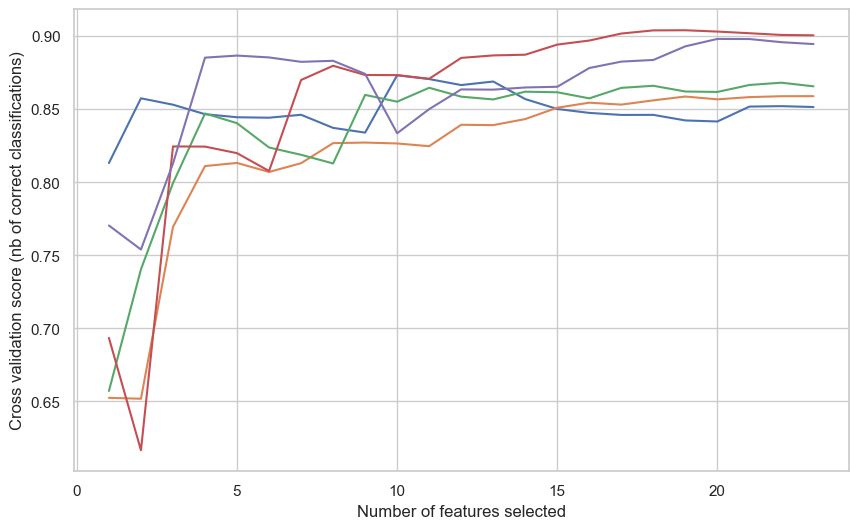

In [23]:
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression(), cv=5)
rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train.columns[rfecv.support_])

print(f"Оптимальное число признаков: {rfecv.n_features_}")
print('Выбранные признаки: %s' % selected_features)

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Как видно, у нас 21 оптимальных признаков, при этом, как и говорилось ранее при разведочном анализе, например, признак **enginetype** не входит в оптимальное множество.

Уберем лишние признаки и снова разобьем данные на тестовую и обучающую выборки, повторно применив масштабирование.


In [24]:
df = df.drop('enginetype', axis=1)
df = df.drop('horsepower', axis=1)
df.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,peakrpm,citympg,highwaympg,price
0,3,0,0,0,0,0,0,88.6,168.8,64.1,...,0,130,0,3.47,2.68,9.0,5000,21,27,13495.0
1,3,0,0,0,0,0,0,88.6,168.8,64.1,...,0,130,0,3.47,2.68,9.0,5000,21,27,16500.0
2,1,0,0,0,1,0,0,94.5,171.2,65.5,...,1,152,0,2.68,3.47,9.0,5000,19,26,16500.0
3,2,0,0,1,2,2,0,99.8,176.6,66.2,...,0,109,0,3.19,3.40,10.0,5500,24,30,13950.0
4,2,0,0,1,2,1,0,99.4,176.6,66.4,...,2,136,0,3.19,3.40,8.0,5500,18,22,17450.0


In [25]:
x = df.drop(['price'], axis=1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Подбор гиперпараметров модели

In [26]:
alpha_grid = np.logspace(-3, 3, 10)
tol_grid = np.logspace(-3, 3, 10)
searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid, "tol": tol_grid}], scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid=[{'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                          'tol': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])}],
             scoring='neg_root_mean_squared_error')

In [27]:
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)
best_epsilon = searcher.best_params_["tol"]
print("Best epsilon = %.4f" % best_epsilon)

Best alpha = 10.0000
Best epsilon = 0.0010


Будем использовать подобранные оптимальные значения в дальнейшем при использовании нашей модели.

Функция линейной модели:

In [28]:
def linear_model(X, w):
    # Добавляем фиктивный признак
    copy_X = X.copy()
    if X.ndim == 1:
        copy_X = copy_X.reshape(-1, 1)

    ones_vec = np.ones((copy_X.shape[0], 1))
    X_with_fictive_feature = np.hstack([ones_vec, copy_X])
    return np.matmul(X_with_fictive_feature, w)

## Обучение модели

In [29]:
W = gradient_descent(x_train_scaled, y_train, alpha=best_alpha, epsilon=best_epsilon)
W

array([12520.55337908,   415.5999997 ,   288.90416067,   590.56521103,
         368.31153549,  -452.02497826, -1148.32620866,  1694.81957696,
         827.23926586,   -63.05403614,  1154.5314422 ,   305.08376445,
         921.73090552,  1547.22312004,  3135.41314699,  -415.90519913,
         -37.40051898,  -217.25220392,   -24.40514101,   728.70681384,
        -156.13611728,   357.26781836])

Обучим нашу модель и предскажем значения для тестовой выборки, а также выведем различные ошибки:

In [30]:
y_train_pred1 = linear_model(x_train_scaled, W)
y_test_pred1 = linear_model(x_test_scaled, W)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred1, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred1, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred1, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred1, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred1))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred1))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred1))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred1))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred1))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred1))

Test RMSE = 3440.8616
Train RMSE = 2423.0581
Test MSE = 11839528.8405
Train MSE = 5871210.6601
Test MAE = 2117.4988
Train MAE = 1754.7212
Test MAPE = 0.1510
Train MAPE = 0.1367
Test R^2 = 0.8159
Train R^2 = 0.9070


Сравним собственную реализацию и значения ошибок с библиотечной реализацией:

В качестве библиотечной реализации возьмем Ridge (с L2 регуляризацией), а также передадим оптимальные значения гиперпараметров.

In [31]:
model = Ridge(alpha=best_alpha, tol=best_epsilon)

model.fit(x_train_scaled, y_train)
y_train_pred2 = model.predict(x_train_scaled)
y_test_pred2 = model.predict(x_test_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred2, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred2, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred2, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred2, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred2))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred2))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred2))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred2))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred2))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred2))

Test RMSE = 3369.4571
Train RMSE = 2259.3361
Test MSE = 11353240.9723
Train MSE = 5104599.6995
Test MAE = 2169.7180
Train MAE = 1609.6184
Test MAPE = 0.1565
Train MAPE = 0.1241
Test R^2 = 0.8234
Train R^2 = 0.9191


Как видно, мы получили практически одинаковые результаты в сравнении с библиотечной моделью. Так, практически везде совпадают значения ошибок и коэффиценты R2 для обучающей и тестовой выборок.

Сравним также результаты с глупым предсказателем:

In [32]:
stupid_pred = y_train.mean()
print("Test RMSE with stupid predictor =", mean_squared_error(y_test, stupid_pred * np.ones(y_test.shape),
                                                              squared=False))
print("Train RMSE with stupid predictor =", mean_squared_error(y_train, stupid_pred * np.ones(y_train.shape),
                                                               squared=False))

Test RMSE with stupid predictor = 8028.407091186176
Train RMSE with stupid predictor = 7944.885473822074


Значение RMSE глупого предсказателя сильно отличается от нашей и библиотечной модели.

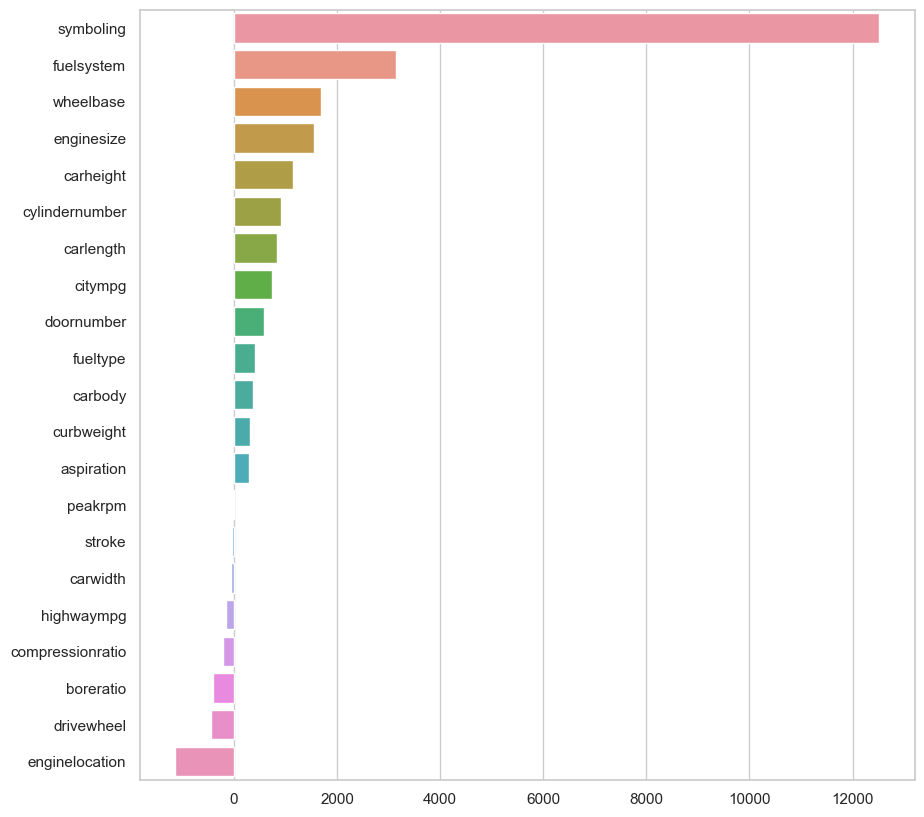

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

sorted_weights = sorted(zip(W, df.columns, x_train_scaled.std(axis=0)), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
sns.barplot(y=features, x=weights, ax=ax)
plt.show()

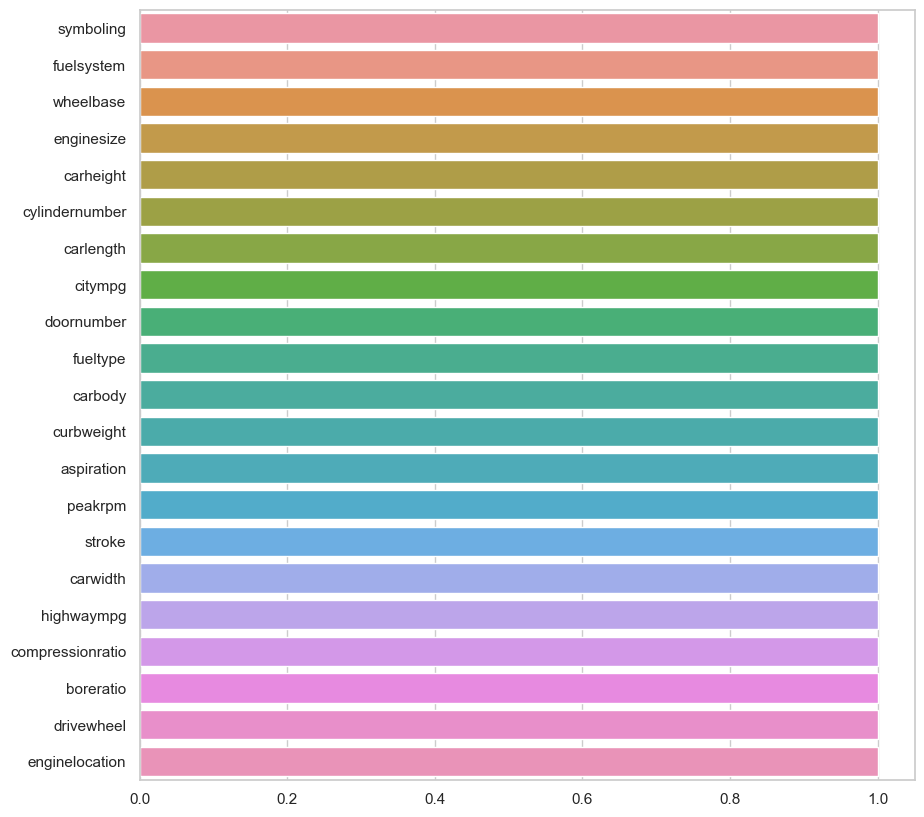

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
scales = [x[2] for x in sorted_weights]
sns.barplot(y=features, x=scales, ax=ax)
plt.show()

Как видим, с применением регуляризации и масштабирования, оценка важности признаков и сама регуляризация стали правильнее и честнее.

### Кросс-валидация

Рассмотрим также обучение нашей модели, используя кросс-валидацию, а также сравним с библиотечной кросс-валидацией.

Для каждого из разбиения, то есть для каждой отдельной модели снова выполним подбор оптимальных гиперпараметров.

In [71]:
pd.set_option('display.float_format', '{:.5f}'.format)
results_df = pd.DataFrame(index=['mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'])

kf = model_selection.KFold(n_splits=5)
scores = []

x_train_scaled_df = pd.DataFrame(x_train_scaled)
for fold, (train, test) in enumerate(kf.split(X=x_train_scaled_df, y=y_train)):
    searcher.fit(x_train_scaled_df.iloc[train, :], y_train.iloc[train])
    best_alpha_fold = searcher.best_params_["alpha"]
    best_epsilon_fold = searcher.best_params_["tol"]
    W = gradient_descent(x_train_scaled_df.iloc[train, :], y_train.iloc[train], alpha=best_alpha_fold, epsilon=best_epsilon_fold)
    y_fold_train = linear_model(x_train_scaled_df.iloc[train, :], W)
    y_fold_test = linear_model(x_train_scaled_df.iloc[test, :], W)
    mse_train = mean_squared_error(y_train.iloc[train], y_fold_train, squared=True)
    mse_test = mean_squared_error(y_train.iloc[test], y_fold_test, squared=True)

    rmse_train = mean_squared_error(y_train.iloc[train], y_fold_train, squared=False)
    rmse_test = mean_squared_error(y_train.iloc[test], y_fold_test, squared=False)

    r2_train = r2_score(y_train.iloc[train], y_fold_train)
    r2_test = r2_score(y_train.iloc[test], y_fold_test)

    results_df.insert(fold, f"Fold {fold + 1}", [
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

mean = results_df.mean(axis=1)
std = results_df.std(axis=1)
results_df['Mean'] = mean
results_df['STD'] = std
results_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
mse-train,6031355.68550,3931812.69111,6536486.44209,6590110.05235,4777556.41732,5573464.25767,1172511.63273
mse-test,9108791.96496,12090959.83713,6998379.70949,7432742.32796,5642884.33809,8254751.63552,2475979.54091
rmse-train,2455.88185,1982.87990,2556.65532,2567.12097,2185.76221,2349.66005,256.32477
rmse-test,3018.07753,3477.20575,2645.44509,2726.30562,2375.47560,2848.50192,419.50635
r2-train,0.90546,0.92989,0.90251,0.90065,0.92317,0.91234,0.01329
r2-test,0.84918,0.86481,0.84903,0.85111,0.91567,0.86596,0.02855


In [36]:
ridge_df = pd.DataFrame(index=['mse', 'rmse', 'mape', 'mae', 'r2'])
cv_mse = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
cv_rmse = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
cv_mape = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
cv_mae = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
cv_r2 = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="r2")

for i in range(cv_mse.size):
    ridge_df.insert(i, f"Fold {i + 1}", [-cv_mse[i], -cv_rmse[i], -cv_mape[i], -cv_mae[i], cv_r2[i]])

mean = ridge_df.mean(axis=1)
std = ridge_df.std(axis=1)
ridge_df['Mean'] = mean
ridge_df['STD'] = std
ridge_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
mse,8784658.14018,12108566.57531,4985870.83698,5040937.38364,5657569.15210,7315520.41764,3101671.10859
rmse,2963.89240,3479.73657,2232.90637,2245.20319,2378.56452,2660.06061,547.26363
mape,2963.89240,3479.73657,2232.90637,2245.20319,2378.56452,2660.06061,547.26363
mae,2963.89240,3479.73657,2232.90637,2245.20319,2378.56452,2660.06061,547.26363
r2,0.85455,0.86462,0.89245,0.89902,0.91545,0.88522,0.02511


**Вывод**:
- Видно, что значения MSE, RMSE, R2, полученные для нашей модели как с использованием кросс-валидации, так и без, приближены к значениям библиотечной модели без кросс-валидации и с кросс-валидацией, что говорит о точности нашей модели и алгоритма.

### Стохастический и мини-пакетный градиентный спуск

In [67]:
def stohastic_gradient_descent(X: ndarray, y: ndarray, alpha=1, lambda_value=0.001, epsilon=1E-2, epochs=1000) -> ndarray:
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    W = np.random.randn(n + 1).reshape(n + 1, 1)

    for _ in range(epochs):
        for i in range(m):
            random_index = np.random.randint(0, m)
            X_i = X[random_index, :].reshape(1, n + 1)
            y_i = y[random_index].reshape(1, 1)

            y_estimated = X_i.dot(W)
            error = y_estimated - y_i

            gradient = (1 / m) * (X_i.T.dot(error) + (alpha * W))
            W = W - (lambda_value * gradient)
            # условие остановки алгоритма
            if np.all(abs(lambda_value * gradient) <= epsilon):
                return W
    return W

In [68]:
W_stohastic = stohastic_gradient_descent(x_train_scaled, y_train.to_numpy(), alpha=best_alpha, epsilon=best_epsilon)
y_train_pred_sgd = linear_model(x_train_scaled, W_stohastic)
y_test_pred_sgd = linear_model(x_test_scaled, W_stohastic)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred_sgd, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred_sgd, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred_sgd, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_sgd, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred_sgd))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred_sgd))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred_sgd))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred_sgd))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred_sgd))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred_sgd))

Test RMSE = 13130.3632
Train RMSE = 13360.1959
Test MSE = 172406438.7959
Train MSE = 178494835.8135
Test MAE = 11792.1260
Train MAE = 12170.3236
Test MAPE = 0.9817
Train MAPE = 0.9915
Test R^2 = -1.6813
Train R^2 = -1.8278


Как видно, мы получили другие результаты в сравнении с нашей моделью, обученной с использованием обычного градиентного спуска, и библиотечной. Особенность заключается в том, что стохастический алгоритм градиентного спуска сходится в разы дольше остальных, и дождаться условия остановки, не ограничивая число итераций, достаточно сложно с учетом большого количества признаков в данных и рандомизированной особенности алгоритма. Поэтому приведем метод мини-градиентного спуска, решающий данную проблему и посмотрим на его результаты. Также передадим оптимальные гиперпараметры при обучении модели.

In [51]:
def mini_batch_gradient_descent(X: ndarray, y: ndarray, batch_size, lambda_value=0.01, epsilon=1E-2, epochs=1000) -> (ndarray, int):
    W = np.ones(X.shape[1])
    cost = 0
    for _ in range(epochs):
        for _ in range(int(X.shape[0]/batch_size)):
            idx = random.sample(range(X.shape[0]), batch_size)
            y_exp = np.dot(X[idx], W) + cost
            error = y[idx] - y_exp
            cost = cost - (lambda_value * -2 * np.mean(error))
            gradient = -2 * np.dot(error, X[idx])
            W = W - (lambda_value * gradient)
            # условие остановки алгоритма
            if np.all(abs(lambda_value * gradient) < epsilon):
                return W, cost

    return W, cost

In [49]:
W_mini_batch, cost = mini_batch_gradient_descent(x_train_scaled, y_train.to_numpy(), epsilon=best_epsilon, batch_size=int(x_train_scaled.shape[0]/50))
y_train_pred_mini_batch = np.dot(x_train_scaled, W_mini_batch) + cost
y_test_pred_mini_batch = np.dot(x_test_scaled, W_mini_batch) + cost

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred_mini_batch, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred_mini_batch, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred_mini_batch, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_mini_batch, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred_mini_batch))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred_mini_batch))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred_mini_batch))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred_mini_batch))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred_mini_batch))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred_mini_batch))

Test RMSE = 3597.8178
Train RMSE = 2441.1883
Test MSE = 12944293.1552
Train MSE = 5959400.2811
Test MAE = 2468.9762
Train MAE = 1860.1201
Test MAPE = 0.1752
Train MAPE = 0.1511
Test R^2 = 0.7987
Train R^2 = 0.9056


Как видно, данным методом мы получили гораздо более верные и приближенные к предыдущим результатам значения MSE, MAE, MAPE, RMSE и $R^2$.

Повторим те же действия, используя кросс-валидацию для мини-пакетного градиентного спуска и также выполним поиск оптимальных гиперпараметров:

In [52]:
pd.set_option('display.float_format', '{:.5f}'.format)
results_df = pd.DataFrame(index=['mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'])

kf = model_selection.KFold(n_splits=5)
scores = []

x_train_scaled_df = pd.DataFrame(x_train_scaled)
for fold, (train, test) in enumerate(kf.split(X=x_train_scaled_df, y=y_train)):
    searcher.fit(x_train_scaled_df.iloc[train, :], y_train.iloc[train])
    best_epsilon_fold = searcher.best_params_["tol"]
    W_mini_batch, cost = mini_batch_gradient_descent(x_train_scaled_df.iloc[train, :].to_numpy(), y_train.iloc[train].to_numpy(), epsilon=best_epsilon_fold, batch_size=int(x_train_scaled_df.iloc[train, :].shape[0]/50))
    y_fold_train = np.dot(x_train_scaled_df.iloc[train, :], W_mini_batch) + cost
    y_fold_test = np.dot(x_train_scaled_df.iloc[test, :], W_mini_batch) + cost
    mse_train = mean_squared_error(y_train.iloc[train], y_fold_train, squared=True)
    mse_test = mean_squared_error(y_train.iloc[test], y_fold_test, squared=True)

    rmse_train = mean_squared_error(y_train.iloc[train], y_fold_train, squared=False)
    rmse_test = mean_squared_error(y_train.iloc[test], y_fold_test, squared=False)

    r2_train = r2_score(y_train.iloc[train], y_fold_train)
    r2_test = r2_score(y_train.iloc[test], y_fold_test)

    results_df.insert(fold, f"Fold {fold + 1}", [
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

mean = results_df.mean(axis=1)
std = results_df.std(axis=1)
results_df['Mean'] = mean
results_df['STD'] = std
results_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
mse-train,4725392.83987,9104442.65115,5463445.04127,8899004.51147,5546523.90664,6747761.79008,2083519.14210
mse-test,8809959.49329,12659273.74756,5236608.43469,13773330.31194,7762270.12714,9648288.42292,3528625.22578
rmse-train,2173.79687,3017.35690,2337.40134,2983.11993,2355.10592,2573.35619,396.23177
rmse-test,2968.15759,3557.98732,2288.36370,3711.24377,2786.08509,3062.36749,581.15591
r2-train,0.92593,0.83766,0.91851,0.86585,0.91080,0.89175,0.03822
r2-test,0.85413,0.85846,0.88704,0.72410,0.88400,0.84155,0.06729


По таблице также видно, что полученные значения с использованием кросс-валидации приемлемы.